Чтобы сдать задание, выполните следующую последовательность действий.

1. Загрузите обучающие выборки прошлой недели, перечислите используемые в моделях признаки и посчитайте Qmay — качество прогнозов моделей, настроенных на данных до апреля 2016, в мае 2016.
2. Попробуйте добавить признаки. Используйте идеи, которые мы предложили, или какие-то свои. Обучайте обновлённые модели на данных до апреля 2016 включительно и считайте качество новых прогнозов на мае. Удаётся ли вам улучшить качество? Не нужно ли увеличить сложность регрессионной модели? Если добавляемый признак не улучшает качество, всё равно оставьте доказательства этому в ноутбуке, чтобы ваши коллеги это видели при проверке.
3. Когда вы примете решение остановиться и перестать добавлять признаки, постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза по следующему функционалу:

Qmay=1R∗739∗6∑r=1R∑T=2016.04.3023:002016.05.3117:00∑i=16∣∣y^rT|T+i−yrT+i∣∣.

Убедитесь, что среднее качество прогнозов увеличилось.
4. Переобучите итоговые модели на данных до мая 2016 включительно, постройте прогнозы на июнь для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в уже знакомом вам формате: geoID, histEndDay, histEndHour, step, y
5. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.
6. Загрузите ноутбук в форму.

In [1]:
import matplotlib.pyplot as plt
import sklearn.manifold
import sklearn.decomposition
import numpy as np
import pandas as pd
from sklearn import ensemble, model_selection, metrics, datasets, tree, linear_model
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [81]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### 1й Пункт заданной последовательности действий

Загрузите обучающие выборки прошлой недели, перечислите используемые в моделях признаки и посчитайте Qmay — качество прогнозов моделей, настроенных на данных до апреля 2016, в мае 2016.

In [2]:
%%time
#Считываем сеты для каждого часа и общий сет, кторые получили на прошлой неделе
data_w5_1=pd.read_csv('2019 09 19 data w5_1.csv', header=0)
data_w5_2=pd.read_csv('2019 09 19 data w5_2.csv', header=0)
data_w5_3=pd.read_csv('2019 09 19 data w5_3.csv', header=0)
data_w5_4=pd.read_csv('2019 09 19 data w5_4.csv', header=0)
data_w5_5=pd.read_csv('2019 09 19 data w5_5.csv', header=0)
data_w5_6=pd.read_csv('2019 09 19 data w5_6.csv', header=0)
data=pd.read_csv('2019 09 19 data w5 1.csv', header=0)

Wall time: 1min 5s


In [3]:
data_w5_1.head(3)

,y,d_h,zone,Y,yT,yT_1,yT_2,yT_3,yT_4,yT_5,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
0,80.0,2016-01-01 00:00:00,1075,91.0,-0.282124,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,91.0,2016-01-01 01:00:00,1075,90.0,-0.238345,-0.282098,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90.0,2016-01-01 02:00:00,1075,32.0,-0.242325,-0.238318,-0.282061,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data.head()

,y,d_h,zone,y_1,y_2,y_3,y_4,y_5,y_6,yT,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
0,80.0,2016-01-01 00:00:00,1075,91.0,90.0,32.0,24.0,11.0,7.0,-0.282124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,91.0,2016-01-01 01:00:00,1075,90.0,32.0,24.0,11.0,7.0,9.0,-0.238345,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90.0,2016-01-01 02:00:00,1075,32.0,24.0,11.0,7.0,9.0,18.0,-0.242325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,32.0,2016-01-01 03:00:00,1075,24.0,11.0,7.0,9.0,18.0,22.0,-0.473158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24.0,2016-01-01 04:00:00,1075,11.0,7.0,9.0,18.0,22.0,27.0,-0.504997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Перечисляем используемые в модели признаки
print(np.array(data_w5_1.columns))

['y' 'd_h' 'zone' 'Y' 'yT' 'yT_1' 'yT_2' 'yT_3' 'yT_4' 'yT_5' 'yT_6'
 'yT_24' 'yT_48' 'yT_168' 'S12' 'S24' 'S168' 'S_month' 'sin1' 'cos1'
 'sin2' 'cos2' 'sin3' 'cos3' 'sin4' 'cos4' 'sin5' 'cos5' 'sin6' 'cos6'
 'sin7' 'cos7' 'sin24' 'cos24' 'sin168' 'cos168' 'd_m_1' 'd_m_2' 'd_m_3'
 'd_m_4' 'd_m_5' 'd_m_6' 'd_m_7' 'd_m_8' 'd_m_9' 'd_m_10' 'd_m_11'
 'd_m_12' 'd_m_13' 'd_m_14' 'd_m_15' 'd_m_16' 'd_m_17' 'd_m_18' 'd_m_19'
 'd_m_20' 'd_m_21' 'd_m_22' 'd_m_23' 'd_m_24' 'd_m_25' 'd_m_26' 'd_m_27'
 'd_m_28' 'd_m_29' 'd_m_30' 'd_m_31' 'd_w0' 'd_w1' 'd_w2' 'd_w3' 'd_w4'
 'd_w5' 'd_w6' 'hour0' 'hour1' 'hour2' 'hour3' 'hour4' 'hour5' 'hour6'
 'hour7' 'hour8' 'hour9' 'hour10' 'hour11' 'hour12' 'hour13' 'hour14'
 'hour15' 'hour16' 'hour17' 'hour18' 'hour19' 'hour20' 'hour21' 'hour22'
 'hour23' '1075' '1076' '1077' '1125' '1126' '1127' '1128' '1129' '1130'
 '1131' '1132' '1172' '1173' '1174' '1175' '1176' '1177' '1178' '1179'
 '1180' '1181' '1182' '1183' '1184' '1221' '1222' '1223' '1224' '1225'
 '12

In [6]:
regions=pd.read_csv('regions_more_5.csv', header=0)#считываем данные о регионах где было более 5 поездок в час.
regions['region']=regions['region'].apply(func=str)#Преобразуем номера регионов в формат str

Произведем следующие действия: создадим модели для каждого часа, используя гиперпараметры, полученные на прошлой неделе, обучим их на данных до конца апреля и спрогнозируем май, посчитаем ошибку.

In [7]:
#Создаем массив словарей гиперпараметров.
hiper_param=[{'reg_alpha': 0.5, 'reg_lambda': 0.005},
 {'reg_alpha': 1, 'reg_lambda': 0.005},
 {'reg_alpha': 1, 'reg_lambda': 0.01},
 {'reg_alpha': 0.5, 'reg_lambda': 0.005},
 {'reg_alpha': 0.5, 'reg_lambda': 0.005},
 {'reg_alpha': 0.5, 'reg_lambda': 0.005}]

In [10]:
#Создаем список из сетов для каждого часа
list_of_tables=[data_w5_1, data_w5_2, data_w5_3, data_w5_4, data_w5_5, data_w5_6]

In [14]:
%%time
#В цикле перебираем часы предсказания, создаем модель, обучаем, делаем предсказания. Обучаем на данных по конец апреля.
pred_may=pd.DataFrame(columns=['1','2','3','4','5','6'])#Сюда будем складывать предсказания для каждого часа
for i in range(0,6):
    #Создаем регрессор
    xgb_model= xgb.XGBRegressor(max_depth=10, n_estimators=200, random_state=0, reg_alpha=hiper_param[i]['reg_alpha'],
                                 reg_lambda=hiper_param[i]['reg_lambda'])
    #Обучаем регрессор
    xgb_model.fit(list_of_tables[i][(list_of_tables[i]['d_h']>='2016-02-01 00:00:00')&
                                    (list_of_tables[i]['d_h']<='2016-04-30 23:00:00')][list_of_tables[i].columns[4:]], 
                    list_of_tables[i][(list_of_tables[i]['d_h']>='2016-02-01 00:00:00')&
                                      (list_of_tables[i]['d_h']<='2016-04-30 23:00:00')]['Y'])
    #Делаем предсказания для мая
    pred_m=xgb_model.predict(list_of_tables[i][(list_of_tables[i]['d_h']>='2016-04-30 23:00:00')&
                             (list_of_tables[i]['d_h']<='2016-05-31 17:00:00')][list_of_tables[i].columns[4:]])
     #Записываем предсказания в таблицу предсказаний
    pred_may[str(i+1)]=pred_m
#Заменим отрицательные предсказания на 0
for j in range(1,7):
    for i, val in enumerate(pred_may[str(j)]):
        if val<0:
            pred_may[str(j)][i]=0    

[16:00:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:06:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:24:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 36min 40s


In [15]:
#Рассчитываем ошибку предсказаний:
#Отбираю целевые признаки в отдельную таблицу
data_may=data[data.columns[:9]][(data['d_h']>='2016-04-30 23:00:00')&(data['d_h']<='2016-05-31 17:00:00')].copy()
data_may.index=range(data_may.shape[0])
#Добавляю предсказания
data_may=pd.concat([data_may, pred_may], axis=1)
#В таблице для мая сделаю колонку сумм разностей предсказания и целевого признака
data_may['s']=abs(data_may['1']-data_may['y_1'])+abs(data_may['2']-data_may['y_2'])+abs(data_may['3']-data_may['y_3'])+abs(data_may['4']-data_may['y_4'])+abs(data_may['5']-data_may['y_5'])+abs(data_may['6']-data_may['y_6'])
#Считаю сумму ошибок по регионам
s_may=0
for region in regions['region']:
    s_may=s_may+sum(data_may['s'][data_may['zone']==int(region)])
#Считаю общую ошибку для мая.
Q_may=s_may/102/739/6

In [16]:
Q_may

25.684048139232114

In [26]:
data_may.tail()#Посмотрим как выглядит таблица для расчета ошибки

,y,d_h,zone,y_1,y_2,y_3,y_4,y_5,y_6,1,2,3,4,5,6,s
75373,121.0,2016-05-31 13:00:00,2168,74.0,76.0,122.0,93.0,81.0,103.0,111.246689,113.034126,106.929108,105.393562,132.302597,92.576988,163.470879
75374,74.0,2016-05-31 14:00:00,2168,76.0,122.0,93.0,81.0,103.0,111.0,80.220039,68.086082,103.045357,116.820587,131.137695,130.709152,151.846748
75375,76.0,2016-05-31 15:00:00,2168,122.0,93.0,81.0,103.0,111.0,130.0,68.718430,86.653534,102.936172,121.106308,128.858200,127.103096,120.425621
75376,122.0,2016-05-31 16:00:00,2168,93.0,81.0,103.0,111.0,130.0,123.0,106.094383,120.228409,128.627182,124.536156,134.708099,121.368172,97.826057
75377,93.0,2016-05-31 17:00:00,2168,81.0,103.0,111.0,130.0,123.0,132.0,108.237968,114.113708,106.601677,122.523186,124.417236,119.019402,64.624649


#### 2й Пункт заданной последовательности действий

Добавлю следующие присзнаки: Праздник, Непраздник, Число поездок в зону в час прогнозирования, Число поездок в зону за предыдущие 2 часа, Число поездок в зону за предыдущие 12 часов, Время года теплое, Время года холодное.

Признак поездки в зону: в этот час, за предыдущие 2 часа, за предыдущие 12 часов.

In [27]:
#Считываю сет данных о количествах поездок в зоны за первые шесть месяцев года. Я его собрал в отдельном ноутбуке.
table_6_month_in=pd.read_csv('table_6_month_in.csv', header=0)

In [28]:
columns=['Day_hour']+list(regions['region'])#Создаем список колонок, которые возьмем из исходного файла данных.
data_in=table_6_month_in[columns]#Отбираем только нужные колонки

In [29]:
data_in.head()

,Day_hour,1075,1076,1077,1125,1126,1127,1128,1129,1130,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
0,2016-01-01 00:00:00,106.0,217.0,76.0,102.0,288.0,352.0,366.0,417.0,613.0,...,50.0,0.0,9.0,3.0,3.0,4.0,0.0,4.0,0.0,1.0
1,2016-01-01 01:00:00,103.0,207.0,57.0,115.0,351.0,261.0,317.0,440.0,485.0,...,53.0,0.0,16.0,2.0,3.0,2.0,0.0,3.0,0.0,3.0
2,2016-01-01 02:00:00,73.0,193.0,27.0,101.0,296.0,185.0,243.0,308.0,355.0,...,67.0,0.0,12.0,8.0,11.0,4.0,0.0,4.0,3.0,1.0
3,2016-01-01 03:00:00,77.0,154.0,32.0,79.0,260.0,153.0,191.0,216.0,268.0,...,70.0,0.0,15.0,32.0,14.0,8.0,1.0,16.0,5.0,13.0
4,2016-01-01 04:00:00,67.0,119.0,24.0,47.0,144.0,106.0,144.0,172.0,171.0,...,57.0,0.0,12.0,54.0,16.0,20.0,2.0,20.0,11.0,24.0


In [30]:
#Создаем таблицу куда сложим данные о поездках в зону последовательно для каждой зоны
trips_in=pd.DataFrame(columns=['trips_in'])

In [31]:
%%time
#Переберем все зоны и сложим в таблицу
for region in regions['region']:
    trips_in=trips_in.append(pd.DataFrame(np.array(data_in[region]), columns=['trips_in']), ignore_index=True)

Wall time: 127 ms


In [32]:
trips_in.tail()#Смотрю что получилось

,trips_in
445531,21.0
445532,16.0
445533,6.0
445534,1.0
445535,2.0


In [33]:
#Добавлю признак поездки в зону в таблицы для каждого часа
for table in list_of_tables:
    table['trips_in']=trips_in#Добавляю данные 
    table['trips_in_2']=trips_in.rolling(3).sum()-trips_in#Сумма поездок в зону за предыдущие два часа
    table['trips_in_12']=trips_in.rolling(13).sum()-trips_in#Сумма поездок в зону за предыдущие 12 часов
    # Стандартизируем признаки
    table[['trips_in', 'trips_in_2', 'trips_in_12']]=StandardScaler().fit_transform(table[['trips_in', 'trips_in_2', 'trips_in_12']])

In [34]:
data_w5_3[data_w5_3.columns[-7:]].tail()#Что получилось для часа 3

,2069,2118,2119,2168,trips_in,trips_in_2,trips_in_12
445531,0.0,0.0,0.0,1.0,-0.536846,-0.502315,-0.569445
445532,0.0,0.0,0.0,1.0,-0.558884,-0.546848,-0.575357
445533,0.0,0.0,0.0,1.0,-0.602961,-0.553528,-0.580846
445534,0.0,0.0,0.0,1.0,-0.625000,-0.586927,-0.590980
445535,0.0,0.0,0.0,1.0,-0.620592,-0.620327,-0.602803


Признаки "праздник" и "не праздник"

In [35]:
import holidays
us_holidays = holidays.UnitedStates(state='NY')

In [36]:
%%time
#Добавлю признаки "праздник" и "не праздник" в таблицы для каждого часа
for table in list_of_tables:
    table['holiday'] = np.array([date in us_holidays for date in table['d_h']], dtype='int')
    table['not_holiday']= np.array([date not in us_holidays for date in table['d_h']], dtype='int')

Wall time: 5min 12s


Признаки "Тепло" и "Холодно" создаю из идеи, что до апреля холодное время года, начиная с апреля теплое время года.

In [38]:
%%time
#Добавлю признаки "тепло" и "холодно" в таблицы для каждого часа
for table in list_of_tables:
    table['warm'] = np.array([date >= '2016-03-31 23:00:00' for date in table['d_h']], dtype='int')
    table['cold']= np.array([date <= '2016-03-31 23:00:00' for date in table['d_h']], dtype='int')

Wall time: 839 ms


In [95]:
data_w5_3[data_w5_3.columns[-10:]][22:26]#Посмотрим что получилось, берем переход с первого на второе января.

,2118,2119,2168,trips_in,trips_in_2,trips_in_12,holiday,not_holiday,warm,cold
22,0.0,0.0,0.0,-0.448691,-0.442196,-0.233755,1,0,0,1
23,0.0,0.0,0.0,-0.431060,-0.444423,-0.286114,1,0,0,1
24,0.0,0.0,0.0,-0.439876,-0.444423,-0.339740,0,1,0,1
25,0.0,0.0,0.0,-0.501584,-0.439969,-0.393366,0,1,0,1


In [39]:
data_w5_3[data_w5_3.columns[-10:]].head(3)

,2118,2119,2168,trips_in,trips_in_2,trips_in_12,holiday,not_holiday,warm,cold
0,0.0,0.0,0.0,-0.162189,NaN,NaN,1,0,0,1
1,0.0,0.0,0.0,-0.175412,NaN,NaN,1,0,0,1
2,0.0,0.0,0.0,-0.307644,-0.170547,NaN,1,0,0,1


In [40]:
data_w5_6[data_w5_6.columns[-10:]].tail(3)

,2118,2119,2168,trips_in,trips_in_2,trips_in_12,holiday,not_holiday,warm,cold
445533,0.0,0.0,1.0,-0.602961,-0.553528,-0.580846,0,1,1,0
445534,0.0,0.0,1.0,-0.625000,-0.586927,-0.590980,0,1,1,0
445535,0.0,0.0,1.0,-0.620592,-0.620327,-0.602803,0,1,1,0


#### 3й и 4й Пункт заданной последовательности действий

Создам и обучу XGBoost регрессор с новыми признаками. Гиперпараметры буду определять по сетке, для обучения данные за апрель, для теста данные за май. Предупреждение - считает достаточно долго, у меня ушло почти 5 часов.

In [43]:
#Создаем генератор индексов выборок
def custom_cv (train, test):
    yield train, test

In [44]:
%%time
#Создадим сеты для обучения и предсказаний для остальных часов прогнозов. Обучим модель, сделаем предсказания.
list_of_best_params_xgb=[]#Сюда будем складывать лучшие гиперпараметры регрессоров
list_of_best_score_xgb=[]#Сюда будем складывать ошибки лучших регрессоров
pred_may_xgb=pd.DataFrame(columns=['1','2','3','4','5','6'])#Сюда будем складывать предсказания для мая
pred_june_xgb=pd.DataFrame(columns=['1','2','3','4','5','6'])#Сюда будем складывать предсказания для июня
#Задаем параметры поиска по сетке
parameters_grid_xgb = {
    'reg_alpha':[0.5, 1],
    'reg_lambda':[0.005, 0.01],
    }
i=1
for table in list_of_tables:#Перебираем сеты для каждого часа предсказаний
    #Обнуляем предыдущие сетку и модель, чтоб не занимали память.
    grid_xgb=None
    xgb_model_m=None
    xgb_model_j=None
    #Создаем таблицу данных для обучения и определения гипер-параметров.
    data_exp=table[(table['d_h']>='2016-02-01 00:00:00')&(table['d_h']<='2016-05-31 23:00:00')].copy(deep=True)
    data_exp.index=range(data_exp.shape[0])
    train_ind=data_exp[data_exp['d_h']<='2016-04-30 23:00:00'].index #Массив индексов для тренировки
    test_ind=data_exp[data_exp['d_h']>='2016-05-01 00:00:00'].index #Массив индексов для тестирования и определения гиперпараметров
    #Создаем регрессор
    xgb_model= xgb.XGBRegressor(max_depth=10, n_estimators=200, random_state=0)
    #Создаем сетку
    grid_xgb=model_selection.GridSearchCV(estimator = xgb_model, param_grid = parameters_grid_xgb, 
                        scoring='neg_mean_absolute_error', cv=custom_cv (np.array(train_ind), np.array(test_ind)))
    #Обучаем сетку
    grid_xgb.fit(data_exp[data_exp.columns[4:]], data_exp['Y'])
    #Записываем параметры модели в список
    list_of_best_params_xgb.append(grid_xgb.best_params_)
    #Записываем ошибку модели в список
    list_of_best_score_xgb.append(grid_xgb.best_score_)
    #Обучаем регрессор на данных до апреля Делаем предсказания мая
    xgb_model_m= xgb.XGBRegressor(max_depth=10, n_estimators=200, random_state=0, reg_alpha=grid_xgb.best_params_['reg_alpha'],
                                 reg_lambda=grid_xgb.best_params_['reg_lambda'])
    xgb_model_m.fit(table[(table['d_h']>='2016-02-01 00:00:00')&(table['d_h']<='2016-04-30 23:00:00')][table.columns[4:]], 
                    table[(table['d_h']>='2016-02-01 00:00:00')&(table['d_h']<='2016-04-30 23:00:00')]['Y'])
    pred_m_xgb=xgb_model_m.predict(data_exp[(data_exp['d_h']>='2016-04-30 23:00:00')&
                             (data_exp['d_h']<='2016-05-31 17:00:00')][data_exp.columns[4:]])
        
    #Обучаем регрессор на данных с маем, делаем предсказание на июнь
    xgb_model_j= xgb.XGBRegressor(max_depth=10, n_estimators=200, random_state=0, reg_alpha=grid_xgb.best_params_['reg_alpha'],
                                 reg_lambda=grid_xgb.best_params_['reg_lambda'])
    xgb_model_j.fit(data_exp[data_exp.columns[4:]], data_exp['Y'])
    pred_j_xgb=xgb_model_j.predict(table[(table['d_h']>='2016-05-31 23:00:00')&
                             (table['d_h']<='2016-06-30 17:00:00')][table.columns[4:]])
        
    #Записываем предсказания в таблицу предсказаний
    pred_may_xgb[str(i)]=pred_m_xgb
    pred_june_xgb[str(i)]=pred_j_xgb
    i+=1
#Заменим отрицательные предсказания на 0
for j in range(1,7): #Перебираем каждый час предсказаний
    for i, val in enumerate(pred_may_xgb[str(j)]):#Перебираем все предсказания для определнного часа предсказания
        if val<0:
            pred_may_xgb[str(j)][i]=0
    for i, val in enumerate(pred_june_xgb[str(j)]):
        if val<0:
            pred_june_xgb[str(j)][i]=0
#Отбираю целевые признаки в отдельную таблицу, чтоб рассчитать ошибку
data_may_xgb=data[data.columns[:9]][(data['d_h']>='2016-04-30 23:00:00')&(data['d_h']<='2016-05-31 17:00:00')].copy()
data_may_xgb.index=range(data_may_xgb.shape[0])
#Добавляю предсказания в эту таблицу
data_may_xgb=pd.concat([data_may_xgb, pred_may_xgb], axis=1)
#В таблице для мая сделаю колонку сумм разностей предсказания и целевого признака
data_may_xgb['s']=abs(data_may_xgb['1']-data_may_xgb['y_1'])+abs(data_may_xgb['2']-data_may_xgb['y_2'])+abs(data_may_xgb['3']-data_may_xgb['y_3'])+abs(data_may_xgb['4']-data_may_xgb['y_4'])+abs(data_may_xgb['5']-data_may_xgb['y_5'])+abs(data_may_xgb['6']-data_may_xgb['y_6'])
#Считаю сумму ошибок по регионам
s_may_xgb=0
for region in regions['region']:
    s_may_xgb=s_may_xgb+sum(data_may_xgb['s'][data_may_xgb['zone']==int(region)])
#Считаю общую ошибку для мая.
Q_may_xgb=s_may_xgb/102/739/6


[18:04:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:11:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:30:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:39:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:45:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:00:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [96]:
print ('Ошибка динамических предсказаний для мая:', Q_may_xgb)

Ошибка динамических предсказаний для мая: 24.44196212695326


Ошибка динамических предсказаний для мая снизилась после добавления дополнительных признаков. Была 25.68, стала 24.44.

In [46]:
#Посмотрю ошибки регрессоров для каждого часа предсказаний.
list_of_best_score_xgb

[-18.208768019158942,
 -22.851820690467036,
 -24.833045430425276,
 -26.873397237507557,
 -27.25966426116147,
 -26.80559562471085]

In [47]:
pred_may_xgb.to_csv('pred_may_xgb.csv', index=False)#Запишу предсказания в файл. Чтоб не мучиться если комп встанет.

In [48]:
pred_june_xgb.to_csv('pred_june_xgb.csv', index=False)

Создаем файл для загрузки на Kaggle. Считаем ошибку предсказаний для июня.

In [50]:
# Формируем файл, куда сложим целевые признаки и предсказания
data_june=data[data.columns[:9]][(data['d_h']>='2016-05-31 23:00:00')&(data['d_h']<='2016-06-30 17:00:00')].copy()
data_june.index=range(data_june.shape[0])
data_june=pd.concat([data_june, pred_june_xgb], axis=1)

In [52]:
data_june.tail()

,y,d_h,zone,y_1,y_2,y_3,y_4,y_5,y_6,1,2,3,4,5,6
72925,1.0,2016-06-30 13:00:00,2168,0.0,0.0,2.0,1.0,1.0,1.0,11.639036,4.996800,17.009499,11.037827,13.823993,13.740526
72926,0.0,2016-06-30 14:00:00,2168,0.0,2.0,1.0,1.0,1.0,0.0,2.633125,7.825344,23.014040,7.716450,16.038448,13.175240
72927,0.0,2016-06-30 15:00:00,2168,2.0,1.0,1.0,1.0,0.0,1.0,13.058683,10.015105,26.513035,13.439780,17.340549,15.929362
72928,2.0,2016-06-30 16:00:00,2168,1.0,1.0,1.0,0.0,1.0,0.0,10.578424,7.716975,15.566803,10.193883,16.940033,14.152299
72929,1.0,2016-06-30 17:00:00,2168,1.0,1.0,0.0,1.0,0.0,0.0,15.215336,11.548388,30.793043,13.091097,20.401304,22.001619


In [53]:
#Формирую таблицу для загрузки на Кагл. В цикле перебираю строчки таблицы предсказаний для июня и заполняю массивы id и y.
ids=[]
ys=[]
for i in range(data_june.shape[0]):
    for j in range(1,7):
        ids.append(str(data_june['zone'][i])+'_'+str(data_june['d_h'][i])[:10]+'_'+str(int(str(data_june['d_h'][i])[11:13]))+'_'+str(j))
        ys.append(data_june[str(j)][i])

In [54]:
#Создаю таблицу как просят в задании
dyn_pred_june=pd.DataFrame(ids, columns=['id'])
dyn_pred_june['y']=ys

In [55]:
dyn_pred_june.tail()

,id,y
437575,2168_2016-06-30_17_2,11.548388
437576,2168_2016-06-30_17_3,30.793043
437577,2168_2016-06-30_17_4,13.091097
437578,2168_2016-06-30_17_5,20.401304
437579,2168_2016-06-30_17_6,22.001619


In [56]:
dyn_pred_june.to_csv('dyn_pred_june_w6.csv', index=False)#Записываем в файл динамические предсказания для июня.

In [57]:
#В таблице для июня сделаю колнку сумм разностей предсказания и целевого признака
data_june['s']=abs(data_june['1']-data_june['y_1'])+abs(data_june['2']-data_june['y_2'])+abs(data_june['3']-data_june['y_3'])+abs(data_june['4']-data_june['y_4'])+abs(data_june['5']-data_june['y_5'])+abs(data_june['6']-data_june['y_6'])
#Считаю сумму ошибок по регионам
s_june=0
for region in regions['region']:
    s_june=s_june+sum(data_june['s'][data_june['zone']==int(region)])
#Считаю общую ошибку для июня.
Q_june=s_june/data_june.shape[0]/6
print (Q_june)

21.499276606825674


Ошибка предсказаний за июнь снизилась. По пятой неделе ошибка была 22.52, по шестой неделе ошибка 21.5.

 Построю графики для одной из зон (зона 1282) для 6го часа предсказаний для визуальной оценки результатов работы моделей.
 В начале сбор данных в одну таблицу.

In [78]:
%%time
#Считываю файл динамических предсказаний для июня, сделанный на неделе 4 и на 5.
dyn_pred_4=pd.read_csv('dyn_pred_june.csv', header=0)
dyn_pred_5=pd.read_csv('dyn_pred_june_w5_1.csv', header=0)
# Добавляем столбец зоны
dyn_pred_4['zone']=dyn_pred_4['id'].apply(lambda x: x[0:4])
dyn_pred_5['zone']=dyn_pred_5['id'].apply(lambda x: x[0:4])
# Добавляем столбец номер часа предсказаний
dyn_pred_4['num']=dyn_pred_4['id'].apply(lambda x: x[-1:])
dyn_pred_5['num']=dyn_pred_5['id'].apply(lambda x: x[-1:])
#Создаем таблицу для региона 1282
dyn_1282=dyn_pred_4[(dyn_pred_4['zone']=='1282')&(dyn_pred_4['num']=='6')].copy()#Отбираем предсказания для зоны 1282
dyn_1282.columns=['id','Sarimax', 'zone', 'num']
#Добавляем значения прогнозов регрессионной моделью по 5й неделе
dyn_1282['Regression w5']=np.array(dyn_pred_5[(dyn_pred_5['zone']=='1282')&(dyn_pred_5['num']=='6')]['y'])
#Добавляем значения прогнозов регрессионной моделью по 6й неделе
dyn_1282['Regression 6w']=np.array(data_june[data_june['zone']==1282]['6'])
#Добавляем значения целевого признака
dyn_1282['fact']=np.array(data_june[data_june['zone']==1282]['y_6'])
#Заменяем индексы на дата-время
dyn_1282.index=pd.to_datetime(data_june['d_h'][data_june['zone']==1282])


Wall time: 1.01 s


In [79]:
dyn_1282.head(2)

,id,Sarimax,zone,num,Regression w5,Regression 6w,fact
d_h,,,,,,,
2016-05-31 23:00:00,1282_2016-05-31_23_6,-206.330178,1282,6,130.514389,131.054459,112.0
2016-06-01 00:00:00,1282_2016-06-01_0_6,109.849570,1282,6,261.061218,276.025238,338.0


<Figure size 1224x936 with 0 Axes>

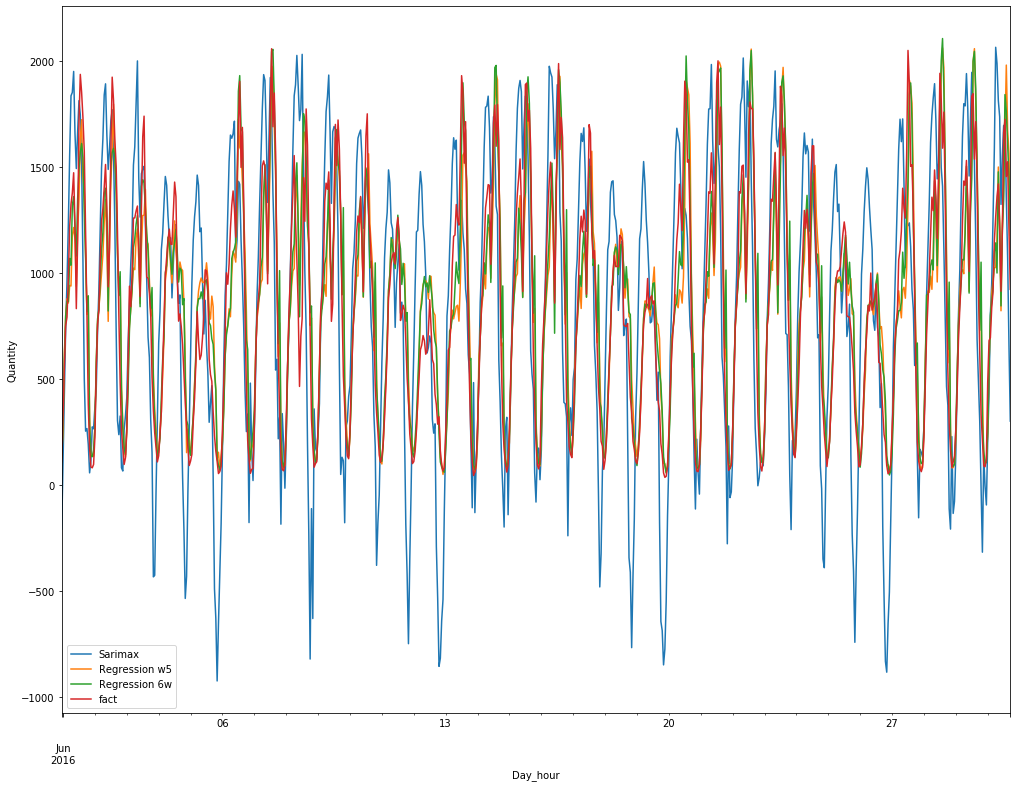

In [85]:
#Построим графики для 1282 зоны за весь июнь.
plt.figure(figsize(17,13))
dyn_1282.plot(y=['Sarimax', 'Regression w5', 'Regression 6w', 'fact'])
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

<Figure size 1224x936 with 0 Axes>

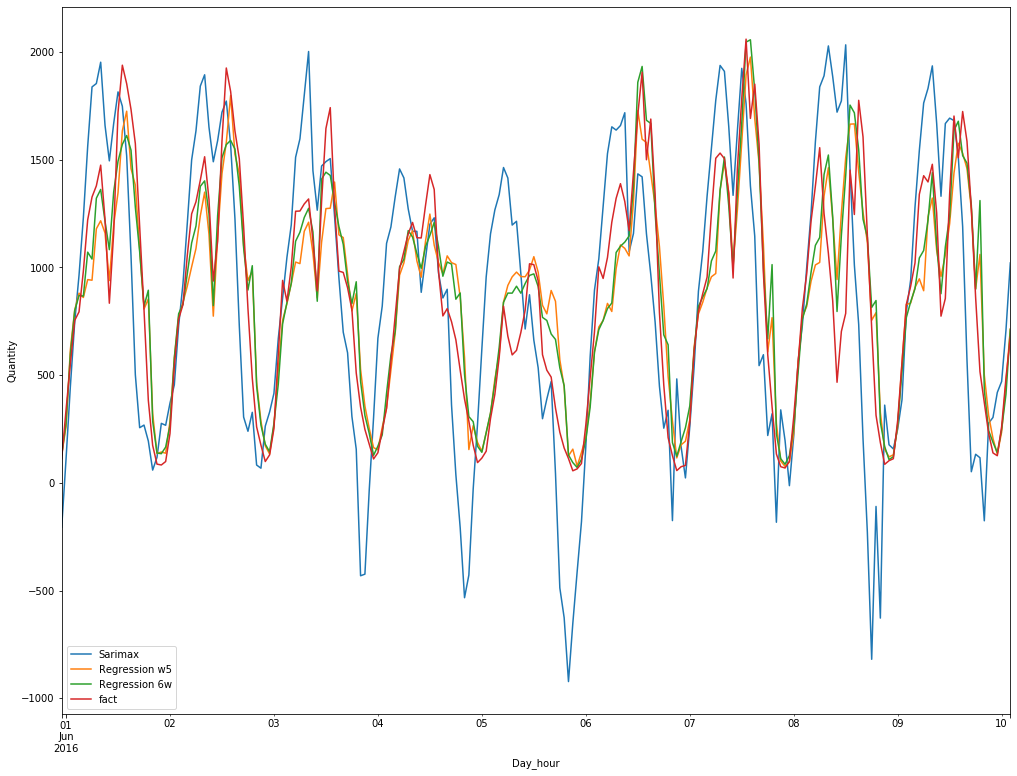

In [86]:
#Построим графики для 1282 зоны на первые 10 дней.
plt.figure(figsize(17,13))
dyn_1282.iloc[:220].plot(y=['Sarimax', 'Regression w5', 'Regression 6w', 'fact'])
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()


Выводы: 
- Судя по графикам, предсказания стали еще чуть точнее. Добавление 3х вещественных и 4х категориальных принесло свой положительный вклад, хотя и не радикальный. 
- Обучение на периоде, длиннее на 1 месяц так же улучшает качество работы модели. Если обучить модель на периоде в год, результаты должны получиться очень хорошими.

Сохраню все полученные данные в файлы.

In [87]:
list_of_best_params_xgb#Смотрю гиперпараметры регрессоров, найденные перебором по сетке.

[{'reg_alpha': 1, 'reg_lambda': 0.01},
 {'reg_alpha': 0.5, 'reg_lambda': 0.01},
 {'reg_alpha': 1, 'reg_lambda': 0.005},
 {'reg_alpha': 0.5, 'reg_lambda': 0.01},
 {'reg_alpha': 0.5, 'reg_lambda': 0.005},
 {'reg_alpha': 1, 'reg_lambda': 0.005}]

In [88]:
best_params_xgb=pd.DataFrame(list_of_best_params_xgb)# Сохраняю гипер параметры регрессоров в таблицу пандас

In [89]:
best_params_xgb

,reg_alpha,reg_lambda
0,1.0,0.010
1,0.5,0.010
2,1.0,0.005
3,0.5,0.010
4,0.5,0.005
5,1.0,0.005


In [92]:
%%time
#Записываем сеты данных для каждого часа и сет гиперпараметров, кторые получили на этой неделе
data_w5_1.to_csv('2019 10 17 data w6_1.csv', index=False)
data_w5_2.to_csv('2019 10 17 data w6_2.csv', index=False)
data_w5_3.to_csv('2019 10 17 data w6_3.csv', index=False)
data_w5_4.to_csv('2019 10 17 data w6_4.csv', index=False)
data_w5_5.to_csv('2019 10 17 data w6_5.csv', index=False)
data_w5_6.to_csv('2019 10 17 data w6_6.csv', index=False)
best_params_xgb.to_csv('best_params_xgb_w6.csv', index=False)

Wall time: 7min 13s


#### 5й Пункт заданной последовательности действий

Ссылка на сабмишн https://inclass.kaggle.com/c/yellowtaxi/submissions?sortBy=date&group=selected&page=1&pageSize=20&turbolinks%5BrestorationIdentifier%5D=1400959e-11a3-4322-ab8a-73e4b24d913c

Место в Leaderboard 107 (Sergey Martynov). Score 21.5